# Recommender with splitted user 

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [2]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [3]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [4]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [5]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [6]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [7]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [9]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [10]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
hybridrecommender.fit(topK=200, alpha = 0.1)

evaluator_validation.evaluateRecommender(hybridrecommender)

P3alphaRecommender: URM Detected 32 (0.40 %) cold users.
P3alphaRecommender: URM Detected 1998 (7.69 %) cold items.
RP3betaRecommender: URM Detected 2 (0.01 %) cold users.
RP3betaRecommender: URM Detected 25 (0.10 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 1998 (7.69 %) cold items.
EvaluatorHoldout: Processed 4923 ( 100.00% ) in 3.87 sec. Users per second: 1273


({10: {'ROC_AUC': 0.19775747302103233,
   'PRECISION': 0.04080845013203239,
   'PRECISION_RECALL_MIN_DEN': 0.1670207706618437,
   'RECALL': 0.1637630920005378,
   'MAP': 0.07729514499354552,
   'MRR': 0.14228838397028554,
   'NDCG': 0.11350461090236702,
   'F1': 0.06533575397344947,
   'HIT_RATE': 0.40808450132033314,
   'ARHR': 0.16315940080413008,
   'NOVELTY': 0.004956735764476893,
   'AVERAGE_POPULARITY': 0.08557736196245594,
   'DIVERSITY_MEAN_INTER_LIST': 0.9900507308693662,
   'DIVERSITY_HERFINDAHL': 0.9989849623672359,
   'COVERAGE_ITEM': 0.49162656400384985,
   'COVERAGE_ITEM_CORRECT': 0.05008662175168431,
   'COVERAGE_USER': 0.6194790486976217,
   'COVERAGE_USER_CORRECT': 0.19239964766578582,
   'DIVERSITY_GINI': 0.1915522686576856,
   'SHANNON_ENTROPY': 12.070334266222464}},
 'CUTOFF: 10 - ROC_AUC: 0.1977575, PRECISION: 0.0408085, PRECISION_RECALL_MIN_DEN: 0.1670208, RECALL: 0.1637631, MAP: 0.0772951, MRR: 0.1422884, NDCG: 0.1135046, F1: 0.0653358, HIT_RATE: 0.4080845, ARHR:

In [11]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_cold = UserKNNCFRecommender(URM_train)
recommender_cold.fit(shrink=100, topK=150, feature_weighting = "TF-IDF")
evaluator_validation.evaluateRecommender(recommender_cold)

UserKNNCFRecommender: URM Detected 32 (0.40 %) cold users.
UserKNNCFRecommender: URM Detected 1998 (7.69 %) cold items.
Similarity column 7947 ( 100 % ), 17725.27 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 4923 ( 100.00% ) in 3.39 sec. Users per second: 1452


({10: {'ROC_AUC': 0.16585314639092855,
   'PRECISION': 0.03410522039406803,
   'PRECISION_RECALL_MIN_DEN': 0.13506911194296953,
   'RECALL': 0.13210424565280618,
   'MAP': 0.0614780042101628,
   'MRR': 0.12034127145339801,
   'NDCG': 0.09198109411961593,
   'F1': 0.054214053147977,
   'HIT_RATE': 0.3410522039406866,
   'ARHR': 0.13696803794305318,
   'NOVELTY': 0.004783377701916095,
   'AVERAGE_POPULARITY': 0.10567952348520045,
   'DIVERSITY_MEAN_INTER_LIST': 0.9855138412330053,
   'DIVERSITY_HERFINDAHL': 0.9985313655606104,
   'COVERAGE_ITEM': 0.3484504331087584,
   'COVERAGE_ITEM_CORRECT': 0.03557266602502406,
   'COVERAGE_USER': 0.6194790486976217,
   'COVERAGE_USER_CORRECT': 0.16219957216559708,
   'DIVERSITY_GINI': 0.10051732310473187,
   'SHANNON_ENTROPY': 11.117358638959619}},
 'CUTOFF: 10 - ROC_AUC: 0.1658531, PRECISION: 0.0341052, PRECISION_RECALL_MIN_DEN: 0.1350691, RECALL: 0.1321042, MAP: 0.0614780, MRR: 0.1203413, NDCG: 0.0919811, F1: 0.0542141, HIT_RATE: 0.3410522, ARHR: 0

In [12]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender_item_cf = ItemKNNCFRecommender(URM_train)
recommender_item_cf.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")
evaluator_validation.evaluateRecommender(recommender_item_cf)

ItemKNNCFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCFRecommender: URM Detected 1998 (7.69 %) cold items.
Similarity column 25975 ( 100 % ), 5994.65 column/sec, elapsed time 0.07 min
EvaluatorHoldout: Processed 4923 ( 100.00% ) in 4.10 sec. Users per second: 1200


({10: {'ROC_AUC': 0.16115218008118723,
   'PRECISION': 0.032602071907373,
   'PRECISION_RECALL_MIN_DEN': 0.12638143279520503,
   'RECALL': 0.1234056921366417,
   'MAP': 0.05828733985487874,
   'MRR': 0.1155591344805239,
   'NDCG': 0.08707181177844174,
   'F1': 0.0515779618209621,
   'HIT_RATE': 0.32602071907373553,
   'ARHR': 0.13172378437460733,
   'NOVELTY': 0.00504647660495856,
   'AVERAGE_POPULARITY': 0.06953101289266372,
   'DIVERSITY_MEAN_INTER_LIST': 0.993021354540542,
   'DIVERSITY_HERFINDAHL': 0.9992819643926173,
   'COVERAGE_ITEM': 0.4520885466794995,
   'COVERAGE_ITEM_CORRECT': 0.03803657362848893,
   'COVERAGE_USER': 0.6194790486976217,
   'COVERAGE_USER_CORRECT': 0.15628539071347677,
   'DIVERSITY_GINI': 0.16848570229767557,
   'SHANNON_ENTROPY': 12.056441541820686}},
 'CUTOFF: 10 - ROC_AUC: 0.1611522, PRECISION: 0.0326021, PRECISION_RECALL_MIN_DEN: 0.1263814, RECALL: 0.1234057, MAP: 0.0582873, MRR: 0.1155591, NDCG: 0.0870718, F1: 0.0515780, HIT_RATE: 0.3260207, ARHR: 0.13

In [13]:
recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=100, shrink=400, feature_weighting = 'TF-IDF')

ItemKNNCBFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCBFRecommender: URM Detected 1998 (7.69 %) cold items.
Similarity column 25975 ( 100 % ), 4128.07 column/sec, elapsed time 0.10 min


In [14]:
from Base.NonPersonalizedRecommender import TopPop

recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

TopPopRecommender: URM Detected 32 (0.40 %) cold users.
TopPopRecommender: URM Detected 1998 (7.69 %) cold items.


In [160]:
# userei un CF per warm 
# CBF per i cold 

In [20]:
grouped_users = dataset.groupby(['row']).count()
MAP_p3aplha_rp3beta_per_group = []
MAP_user_cf_cold_per_group = []
MAP_item_cf_cold_per_group = []
MAP_item_cbf_per_group = []
MAP_top_pop_per_group = []
cutoff = 10

sorted_users = grouped_users.reset_index()['row'].to_numpy()
print(sorted_users)

block_size = int(len(sorted_users)*0.05)
print(block_size)

#sorted_users = np.argsort(profile_length)
#print(sorted_users)

[   0    1    2 ... 7944 7945 7946]
397


In [23]:



for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
    MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
    MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
    MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
    MAP_item_cbf_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
    MAP_top_pop_per_group.append(results[cutoff]["MAP"])

EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 237 ( 100.00% ) in 0.20 sec. Users per second: 1212
EvaluatorHoldout: Processed 237 ( 100.00% ) in 0.19 sec. Users per second: 1254
EvaluatorHoldout: Processed 237 ( 100.00% ) in 0.20 sec. Users per second: 1192
EvaluatorHoldout: Processed 237 ( 100.00% ) in 0.16 sec. Users per second: 1452
EvaluatorHoldout: Processed 237 ( 100.00% ) in 0.23 sec. Users per second: 1053
EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 250 ( 100.00% ) in 0.24 sec. Users per second: 1049
EvaluatorHoldout: Processed 250 ( 100.00% ) in 0.19 sec. Users per second: 1339
EvaluatorHoldout: Processed 250 ( 100.00% ) in 0.25 sec. Users per second: 1009
EvaluatorHoldout: Processed 250 ( 100.00% ) in 0.19 sec. Users per second: 1290
EvaluatorHoldout: Processed 250 ( 100.00% ) in 0.17 sec. Users per second: 1512
EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 236 ( 100.00% ) in 0.17 sec. Users per second: 1362
Evalua

In [ ]:
        

'''users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[users_not_in_group.col >= 3]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])

users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[(users_not_in_group['col'] < 3) | (users_not_in_group['col'] > 10)]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])

users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[users_not_in_group.col <= 10]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])'''

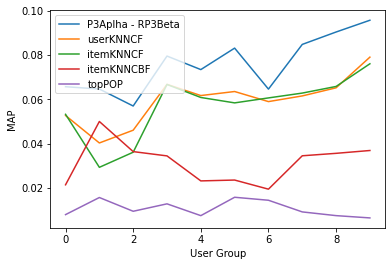

In [24]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
pyplot.plot(MAP_user_cf_cold_per_group, label="userKNNCF")
pyplot.plot(MAP_item_cf_cold_per_group, label="itemKNNCF")
pyplot.plot(MAP_item_cbf_per_group, label="itemKNNCBF")
pyplot.plot(MAP_top_pop_per_group, label="topPOP")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()